
# LAB‑02 — Predicción del **default** usando **Logistic Regression**

Este cuaderno implementa **exactamente** los pasos solicitados en `homework.py` para el taller **LAB‑02-prediccion-del-default-usando-logreg**.
Cada sección está rotulada con **Paso N** como en el enunciado.


## Imports

In [15]:

# flake8: noqa
import os
import gzip
import json
import pickle
import zipfile
from glob import glob
from pathlib import Path

import pandas as pd  # type: ignore

from sklearn.compose import ColumnTransformer  # type: ignore
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler  # type: ignore
from sklearn.feature_selection import SelectKBest, f_classif  # type: ignore
from sklearn.linear_model import LogisticRegression  # type: ignore
from sklearn.pipeline import Pipeline  # type: ignore
from sklearn.model_selection import GridSearchCV  # type: ignore
from sklearn.metrics import (  # type: ignore
    precision_score, recall_score, f1_score, balanced_accuracy_score,
    confusion_matrix
)

# Directorios esperados
FILES_DIR = Path("../files")
INPUT_DIR = FILES_DIR / "input"
MODELS_DIR = FILES_DIR / "models"
OUTPUT_DIR = FILES_DIR / "output"
for d in [FILES_DIR, INPUT_DIR, MODELS_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)



## Paso 1 — Limpieza de los datasets

- Renombrar `default payment next month` → `default`  
- Remover la columna `ID`  
- Eliminar registros con información no disponible (*NA*)  
- En `EDUCATION`, agrupar valores `> 4` como `4` (*others*).


In [16]:

def leer_zip_a_dfs(directorio: str) -> list[pd.DataFrame]:
    dataframes = []
    for zip_path in glob(os.path.join(directorio, "*")):
        with zipfile.ZipFile(zip_path, "r") as zf:
            for miembro in zf.namelist():
                with zf.open(miembro) as fh:
                    df = pd.read_csv(fh, sep=",", index_col=0)
                    df.attrs["__source_zip__"] = zip_path
                    df.attrs["__source_csv__"] = miembro
                    dataframes.append(df)
    return dataframes

def depurar(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    if "default payment next month" in tmp.columns:
        tmp = tmp.rename(columns={"default payment next month": "default"})
    if "ID" in tmp.columns:
        tmp = tmp.drop(columns=["ID"])
    if "MARRIAGE" in tmp.columns:
        tmp = tmp.loc[tmp["MARRIAGE"] != 0]
    if "EDUCATION" in tmp.columns:
        tmp = tmp.loc[tmp["EDUCATION"] != 0]
        tmp["EDUCATION"] = tmp["EDUCATION"].apply(lambda v: 4 if v > 4 else v)
    return tmp.dropna()

dfs = leer_zip_a_dfs(str(INPUT_DIR))

# Intentar detectar train/test por nombre; si no, seguir el orden [test, train]
train_df, test_df = None, None
for d in dfs:
    src = (str(d.attrs.get("__source_zip__")) + " " + str(d.attrs.get("__source_csv__"))).lower()
    if "train" in src:
        train_df = depurar(d)
    elif "test" in src:
        test_df = depurar(d)
if train_df is None or test_df is None:
    df_list = [depurar(d) for d in dfs]
    if len(df_list) >= 2:
        test_df, train_df = df_list[0], df_list[1]
    else:
        raise RuntimeError("No se encontraron suficientes archivos de entrada en files/input/")

print("Shapes depurados:", train_df.shape, test_df.shape)


Shapes depurados: (20953, 24) (8979, 24)



## Paso 2 — División en `x_train`, `y_train`, `x_test`, `y_test`


In [17]:

def separar_xy(df: pd.DataFrame):
    X = df.drop(columns=["default"])
    y = df["default"]
    return X, y

x_train, y_train = separar_xy(train_df)
x_test, y_test = separar_xy(test_df)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((20953, 23), (8979, 23), (20953,), (8979,))


## Paso 3 — Pipeline (OHE → Escalado [0,1] → SelectKBest → LogisticRegression)


In [18]:

#Columnas categoricas
categorical_features=["SEX","EDUCATION","MARRIAGE"]
numerical_features=num_columns = [col for col in x_train.columns if col not in categorical_features]
#print(numerical_features)


#preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('scaler',MinMaxScaler(),numerical_features),
    ],
    remainder="passthrough"
)

#pipeline
pipeline=Pipeline(
    [
        ("preprocessor",preprocessor),
        ('feature_selection',SelectKBest(score_func=f_classif)),
        ('classifier', LogisticRegression(random_state=42))
    ]
)



## Paso 4 — Optimización por **validación cruzada (10-fold)** con **balanced accuracy**


In [19]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score



param_grid = {
    'feature_selection__k':range(1, 11),
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100,200],
}

model=GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True
    )

model.fit(x_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.001, 0.01, ...], 'classifier__max_iter': [100, 200], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear'], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('scaler', ...)]"



## Paso 5 — Guardar el modelo (`gzip`) como `files/models/model.pkl.gz`


In [20]:

def reiniciar_directorio(ruta: str) -> None:
    if os.path.exists(ruta):
        for f in glob(os.path.join(ruta, "*")):
            try:
                os.remove(f)
            except IsADirectoryError:
                pass
        try:
            os.rmdir(ruta)
        except OSError:
            pass
    os.makedirs(ruta, exist_ok=True)

def guardar_modelo_gz(ruta_salida: str, objeto) -> None:
    reiniciar_directorio(os.path.dirname(ruta_salida))
    with gzip.open(ruta_salida, "wb") as fh:
        pickle.dump(objeto, fh)

model_path = MODELS_DIR / "model.pkl.gz"
guardar_modelo_gz(str(model_path), model)
model_path


WindowsPath('../files/models/model.pkl.gz')


## Paso 6 — Métricas (train y test): precision, balanced_accuracy, recall, f1-score


In [21]:

def _metrics_block(y_true, y_pred, dataset_name):
    return {
        "type": "metrics",
        "dataset": dataset_name,
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1_score": float(f1_score(y_true, y_pred, zero_division=0)),
    }

yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

m_train = _metrics_block(y_train, yhat_train, "train")
m_test  = _metrics_block(y_test,  yhat_test,  "test")

m_train, m_test


({'type': 'metrics',
  'dataset': 'train',
  'precision': 0.6939338235294118,
  'balanced_accuracy': 0.6392682710528409,
  'recall': 0.31957671957671957,
  'f1_score': 0.43761773655991887},
 {'type': 'metrics',
  'dataset': 'test',
  'precision': 0.7017913593256059,
  'balanced_accuracy': 0.6547057822566611,
  'recall': 0.34942287513116477,
  'f1_score': 0.46654991243432575})


## Paso 7 — Matrices de confusión (train/test) y escritura de `files/output/metrics.json`


Escrito: ..\files\output\metrics.json


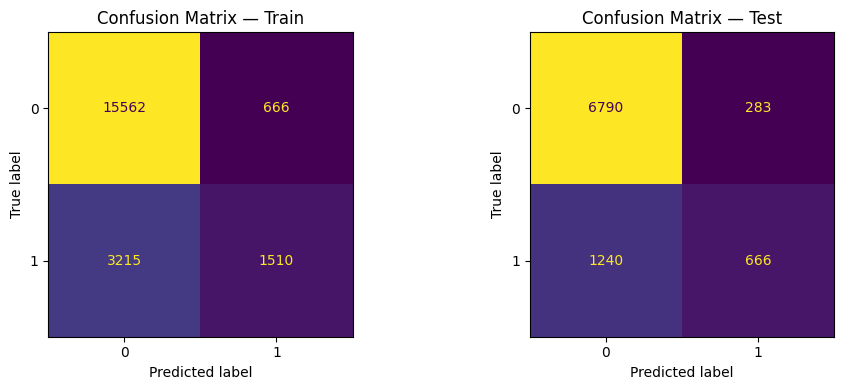

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def _cm_block(y_true, y_pred, dataset_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return {
        "type": "cm_matrix",
        "dataset": dataset_name,
        "true_0": {"predicted_0": int(tn), "predicted_1": int(fp)},
        "true_1": {"predicted_0": int(fn), "predicted_1": int(tp)},
    }

# --- Construcción de bloques para metrics.json ---
cm_train = _cm_block(y_train, yhat_train, "train")
cm_test  = _cm_block(y_test,  yhat_test,  "test")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUTPUT_DIR / "metrics.json", "w", encoding="utf-8") as fh:
    fh.write(json.dumps(m_train) + "\n")
    fh.write(json.dumps(m_test) + "\n")
    fh.write(json.dumps(cm_train) + "\n")
    fh.write(json.dumps(cm_test) + "\n")

print("Escrito:", OUTPUT_DIR / "metrics.json")

# --- Ploteo de matrices de confusión (train / test) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), squeeze=False)

cm_tr = confusion_matrix(y_train, yhat_train, labels=[0, 1])
cm_te = confusion_matrix(y_test,  yhat_test,  labels=[0, 1])

disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=[0, 1])
disp_te = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=[0, 1])

disp_tr.plot(ax=axes[0][0], values_format='d', colorbar=False)
axes[0][0].set_title("Confusion Matrix — Train")

disp_te.plot(ax=axes[0][1], values_format='d', colorbar=False)
axes[0][1].set_title("Confusion Matrix — Test")

plt.tight_layout()
plt.show()



## Resultado
- Modelo: `files/models/model.pkl.gz`  
- Métricas y matrices de confusión: `files/output/metrics.json`


In [25]:

from pprint import pprint
print("Contenido de files/output/metrics.json:\n")
with open(OUTPUT_DIR / "metrics.json", "r", encoding="utf-8") as fh:
    for line in fh:
        pprint(json.loads(line))


Contenido de files/output/metrics.json:

{'balanced_accuracy': 0.6392682710528409,
 'dataset': 'train',
 'f1_score': 0.43761773655991887,
 'precision': 0.6939338235294118,
 'recall': 0.31957671957671957,
 'type': 'metrics'}
{'balanced_accuracy': 0.6547057822566611,
 'dataset': 'test',
 'f1_score': 0.46654991243432575,
 'precision': 0.7017913593256059,
 'recall': 0.34942287513116477,
 'type': 'metrics'}
{'dataset': 'train',
 'true_0': {'predicted_0': 15562, 'predicted_1': 666},
 'true_1': {'predicted_0': 3215, 'predicted_1': 1510},
 'type': 'cm_matrix'}
{'dataset': 'test',
 'true_0': {'predicted_0': 6790, 'predicted_1': 283},
 'true_1': {'predicted_0': 1240, 'predicted_1': 666},
 'type': 'cm_matrix'}
